Jared Miguel F. Roque <br>
CPE 313 - CPE32S8

# Pre-Lab Questions

**What are autoencoders? What is the vanilla/standard/regular architecture of an autoencoder?**
- Autoencoders are a type of neural network used for unsupervised learning, particularly for dimensionality reduction and feature learning.

- Vanilla/Standard architecture of an autoencoder consists of an encoder and a decoder. The encoder compresses the input data into a latent-space representation, while the decoder reconstrucs the original input data from this representation.

**What are the limitations of autoencoders?**
- They are limited by their ability to reconsutrct input data. If the latent space is too small or the model architecture is not sufficiently expressive, the reconstruction quality may be affected.

**Why use variable autoencoders?**
- VAEs are autoencoders that aim to learn a latent-space representation that follows a specific probabilty distribution, typically a Gaussian distribution. VAEs allow for more structured and meaningful representations. VAEs can generate new data samples by sampling from the learned distribution in the latent space.

**What do we mean by generative adversarial networks?**
- GANs are a type of generative model that consists of two neural networks, a generator and a discriminator. The generator generates fake data samples from random noise, while the discriminator evaluates these samples, distinguishing between real and fake data.

#Hands-on Activity 5.1 Generating Images with GANs and VAEs

#Procedures and Discussion: Variational Autoencoders and GANs

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#

print(tf.__version__)

2.15.0


## Part 1: Autoencoders (AEs)

Answer: What is the typical architecture of a 'vanilla/standard/traditional' autoencoder.

### Data: Acquisition and Pre-processing
We will be using Fashion-MNIST, which can be conveniently accessed with Keras.

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


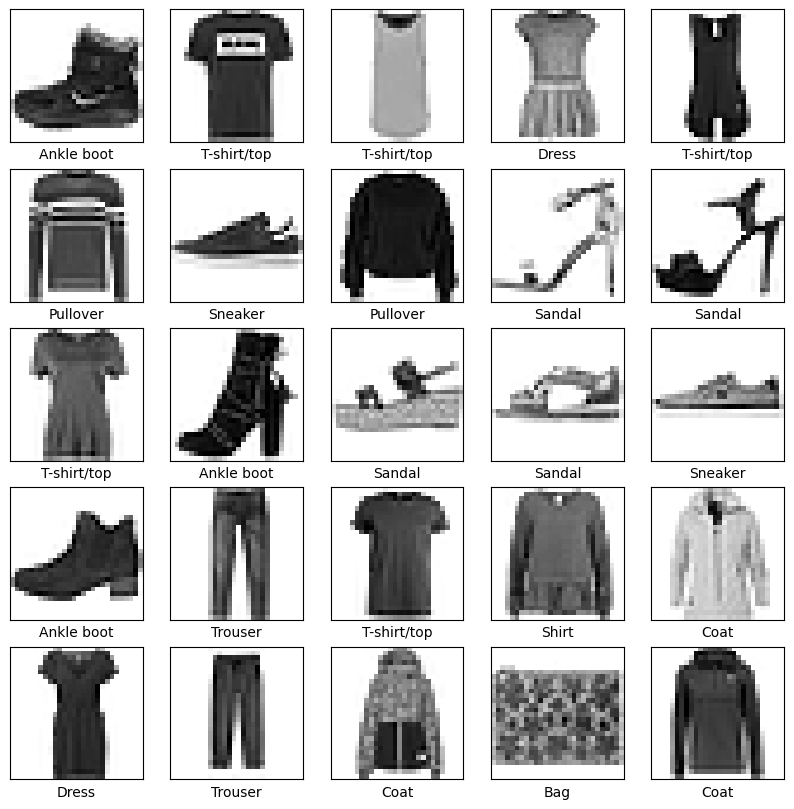

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display the first 25 garments from the training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Add Noise to the Images

In attempt to make the autoencoder more robust and not just memorize the inputs, let's add noise to the inputs but calculate its loss based on how similar its outputs are to the original (non-denoised) images.

Check out imgaug docs for more info and other ways to add noise.

In [ ]:
# Neural Networks want the inputs to be 3D
n_samples, h, w = X_train.shape

X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

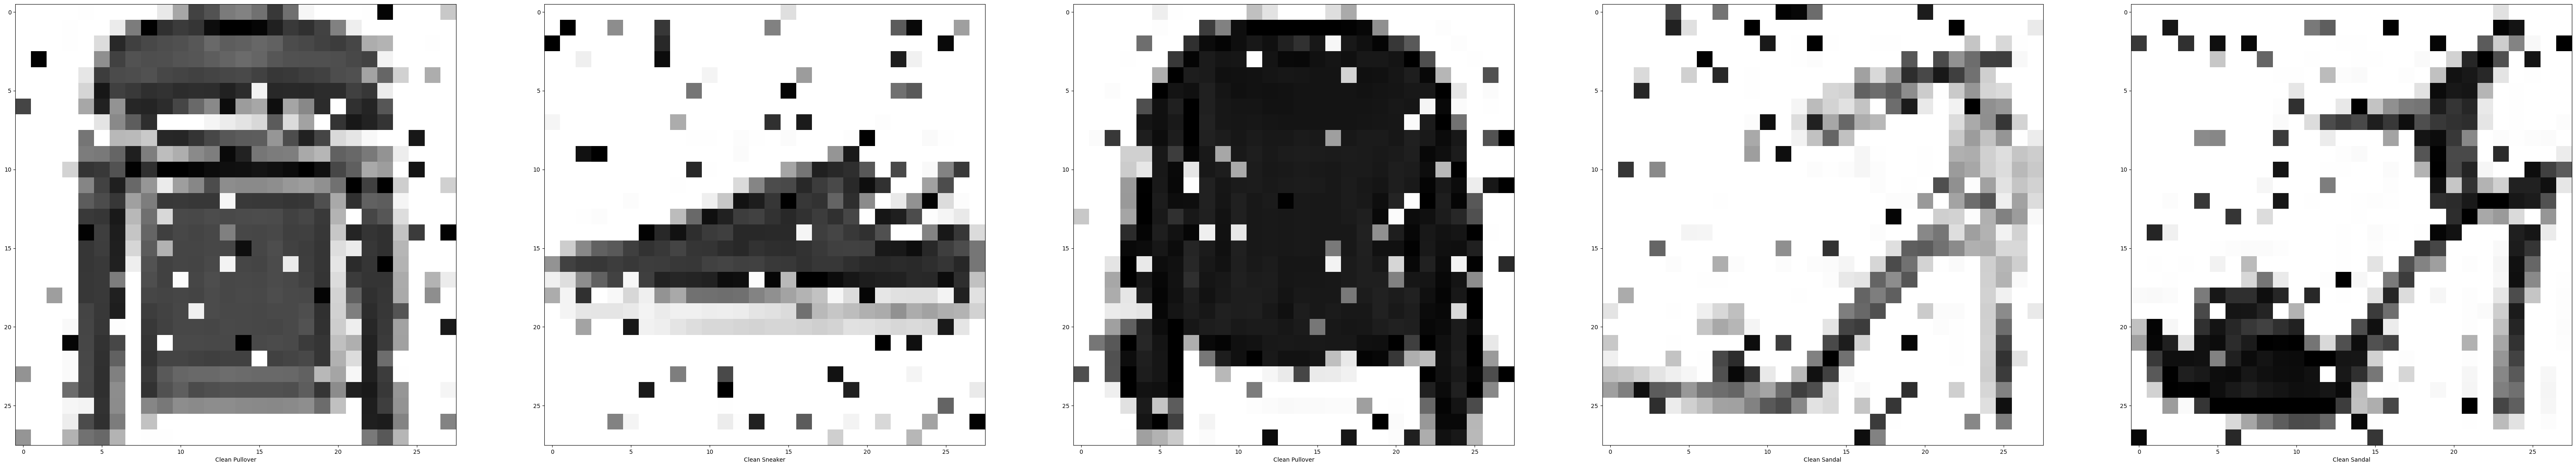

In [ ]:
# Adding some 'salt and pepper' noises
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### Create the Autoencoder

In [ ]:
# input layer
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer3)
output_layer = tf.keras.layers.Conv2D(1,(3, 3), padding='same')(decoded_layer3)

# compile the model
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 16)          4624

#### Train the Autoencoder

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

# epochs=20 for better results
history = model.fit(X_train_n, X_train, epochs=5, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0856 - val_loss: 0.0496
Epoch 2/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0402 - val_loss: 0.0338
Epoch 3/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0311 - val_loss: 0.0283
Epoch 4/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0267 - val_loss: 0.0251
Epoch 5/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0241 - val_loss: 0.0231


In [ ]:
n = np.random.randint(0,len(X_test)-5) # pick a random starting index within our test set

#### Visualize Samples reconstructed by AE

**Denoised Images**

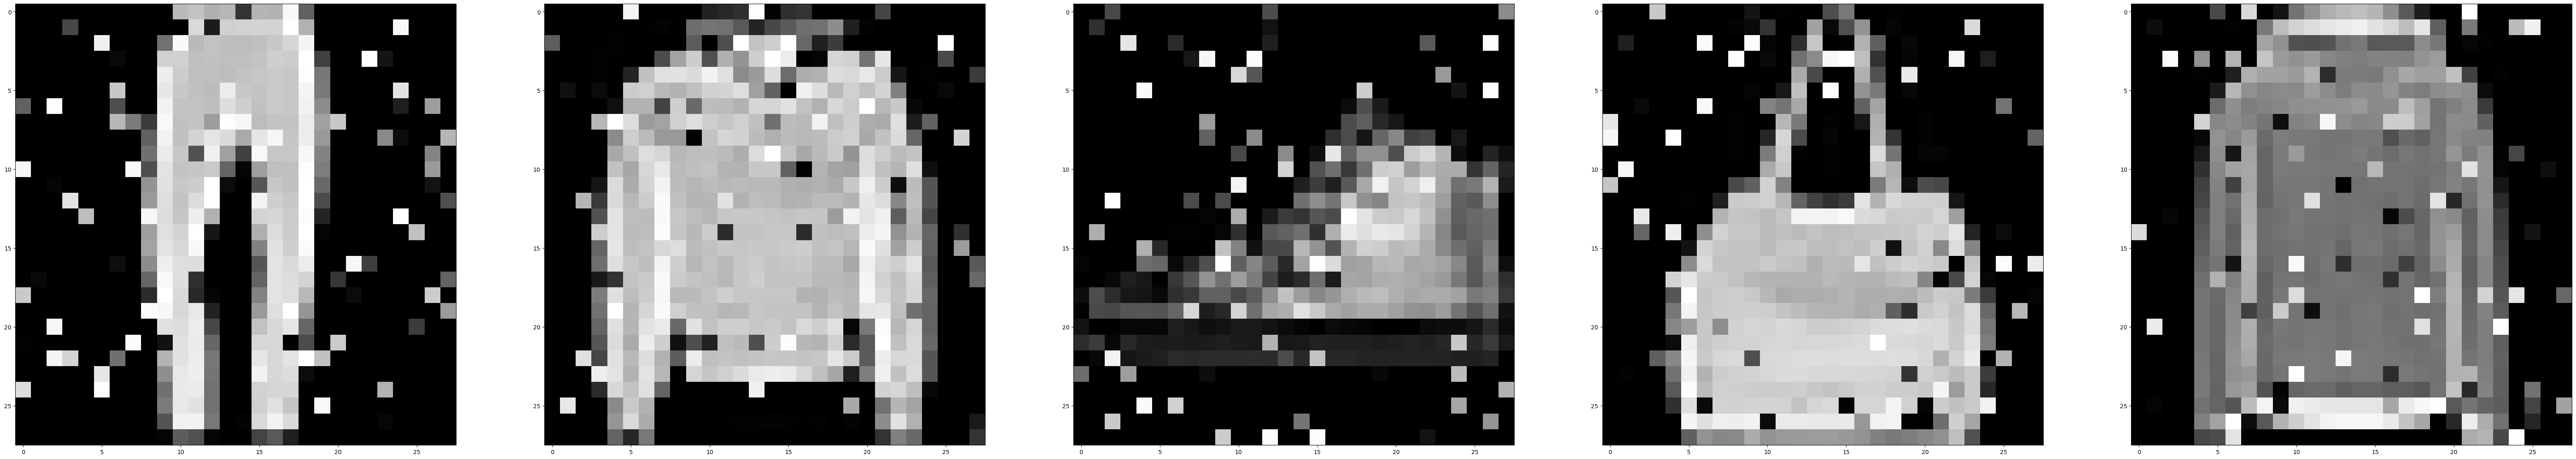

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

**Actual Targets (i.e., Original inputs)**

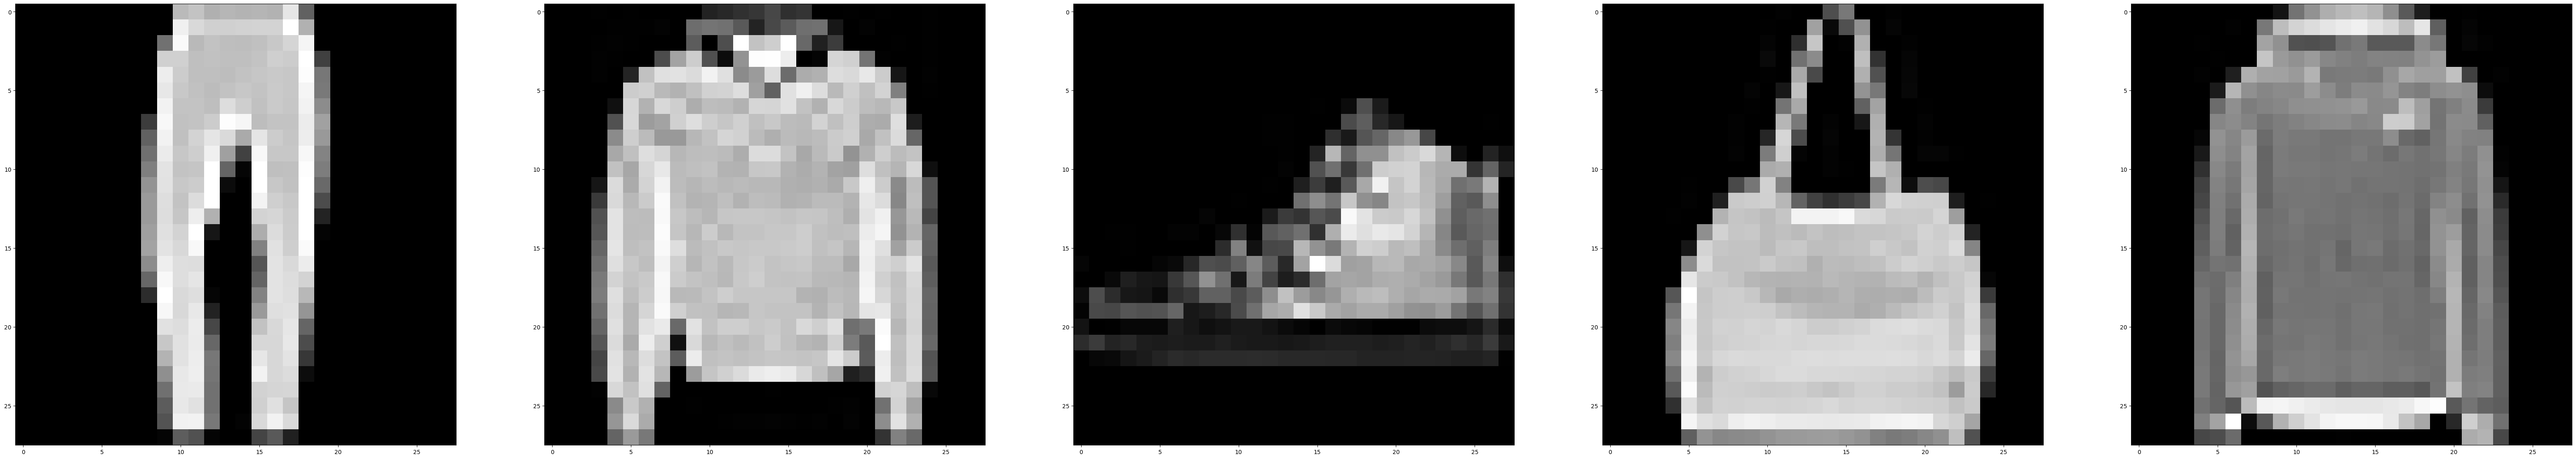

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)): # display the 5 images starting at our random index
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

**Predicted Images**

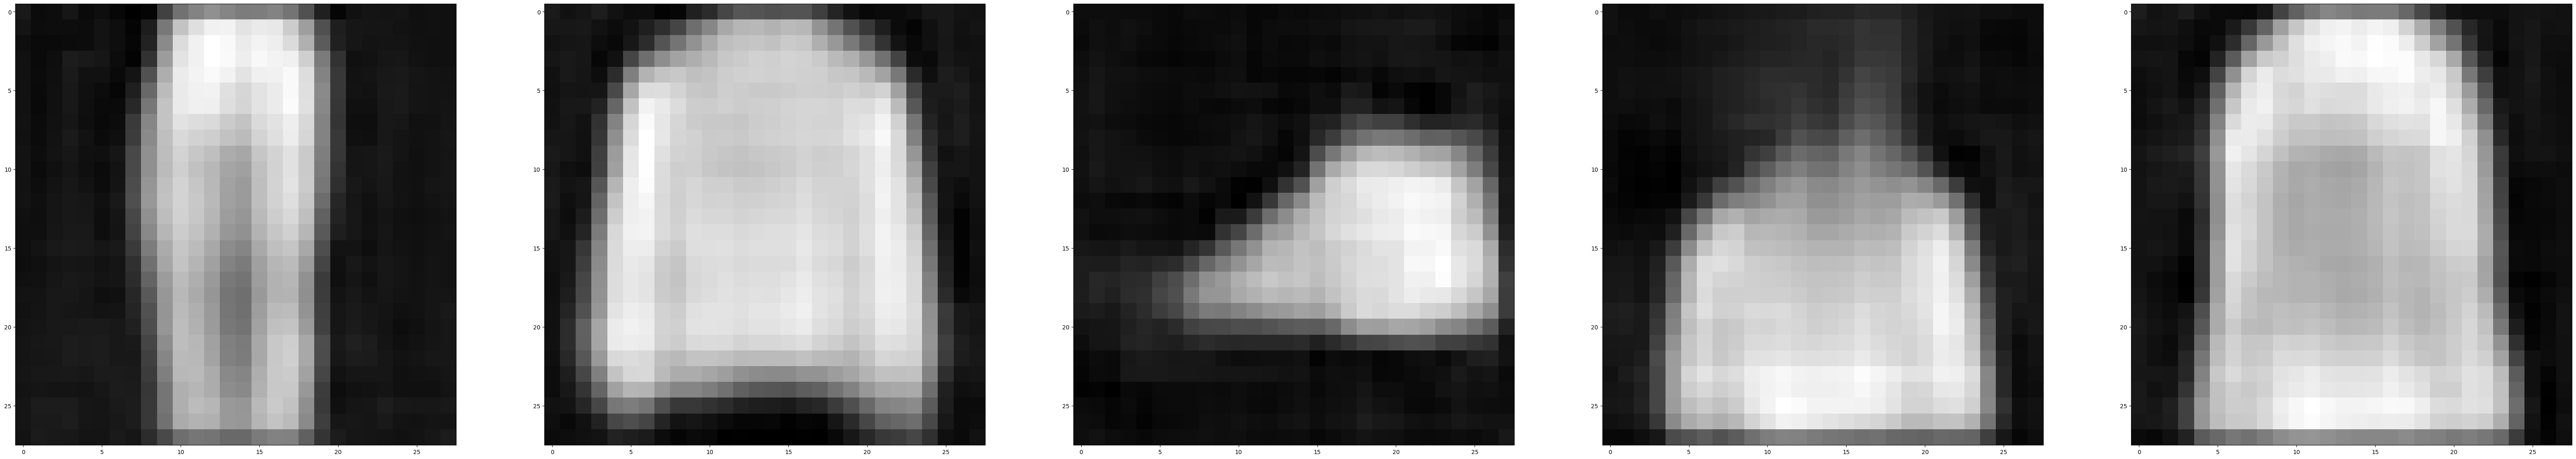

In [ ]:
preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

## Part 2: Variational Autoencoders (VAEs)

**Discussion: Why do we care to use VAEs? Identify the limitations/weaknesses of Autoencoders**

### Reset Data

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


### Setup Encoder Neural Network

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dens  (None, 512)               1536      
 e)                                                              
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

<tf.Tensor 'model_7/original_decoder/Sigmoid:0' shape=(None, 784) dtype=float32>

In [ ]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 intermediate_encoder (Dens  (None, 512)                  401920    ['input[0][0]']               
 e)                                                                                               
                                                                                                  
 latent_encoder (Dense)      (None, 2)                    1026      ['intermediate_encoder[0][0]']
                                                                                                  
 dense_6 (Dense)             (None, 2)                    6         ['latent_encoder[0][0]']

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 16s 271us/sample - loss: 0.4924 - val_loss: 0.4913
Epoch 2/4
60000/60000 [==============================] - 13s 214us/sample - loss: 0.4907 - val_loss: 0.4915
Epoch 3/4
60000/60000 [==============================] - 12s 204us/sample - loss: 0.4906 - val_loss: 0.4914
Epoch 4/4
60000/60000 [==============================] - 12s 203us/sample - loss: 0.4906 - val_loss: 0.4913


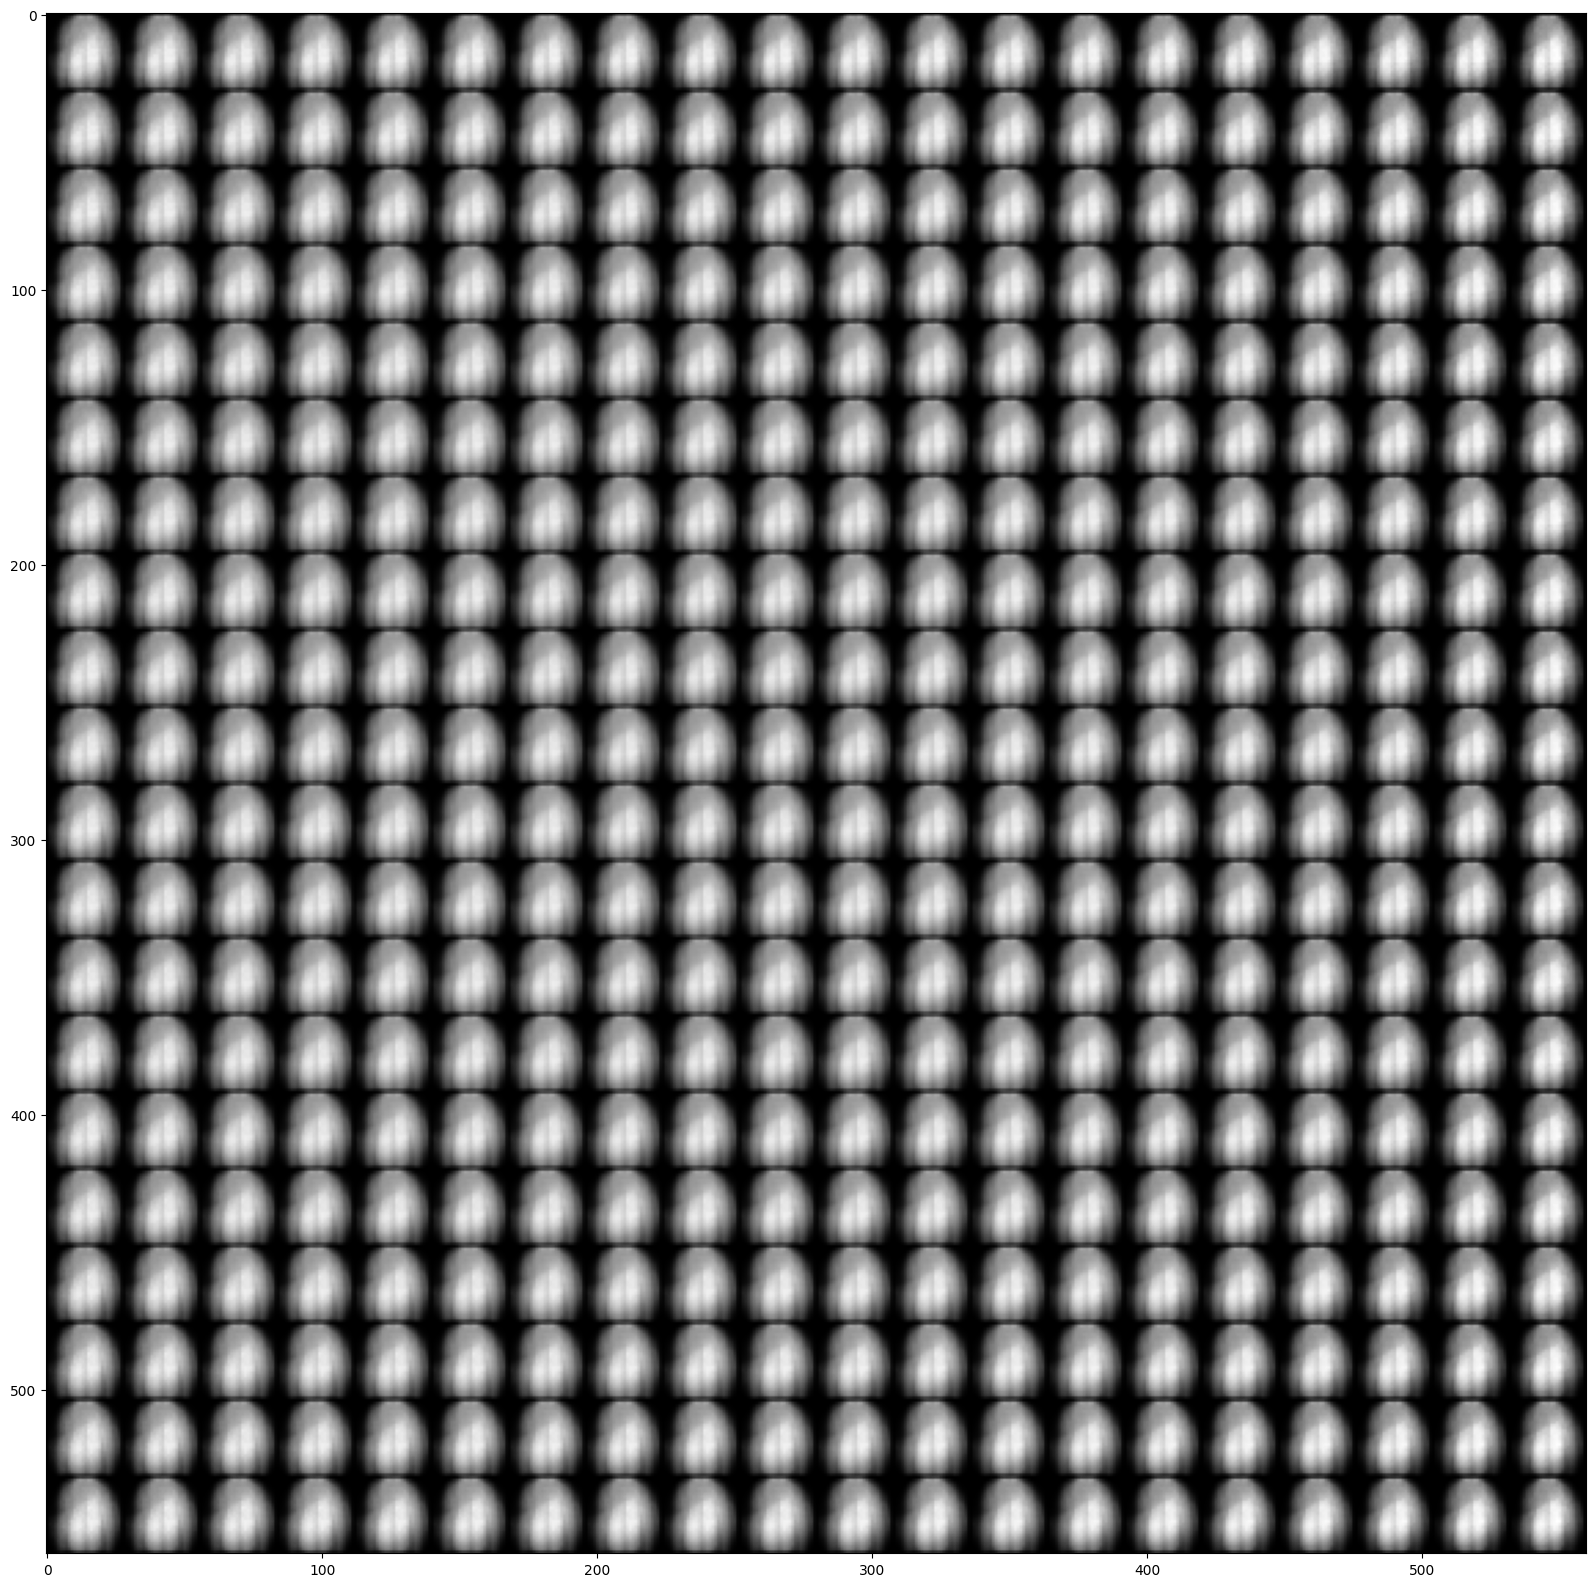

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

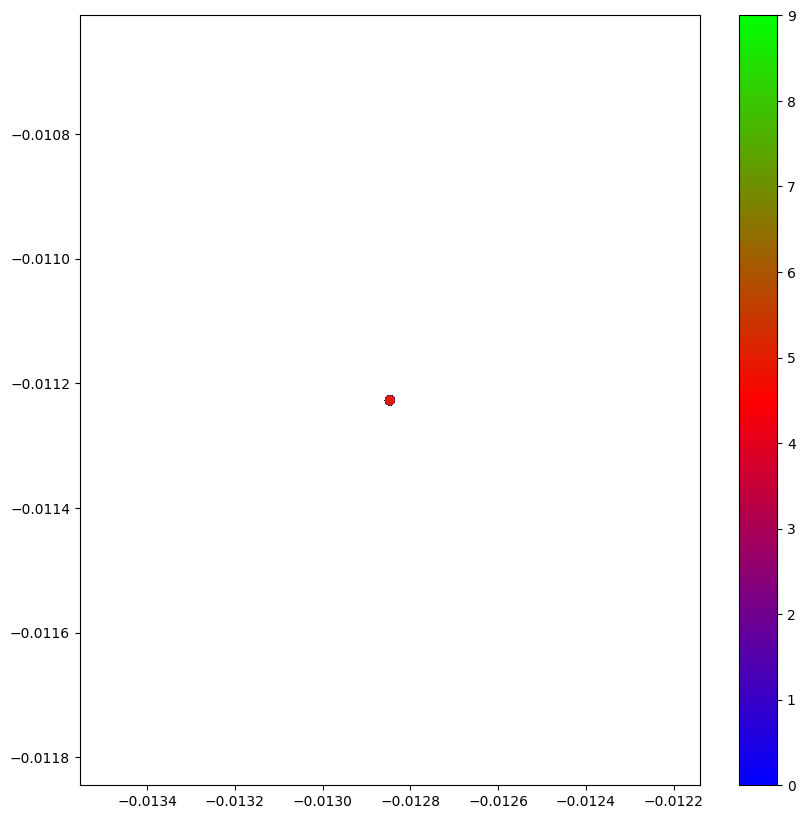

In [ ]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Part 2B: Adding CNNs and KL Divergence Losses

### Generating new fashion

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32,3,padding='same', activation='relu')(input_img)
x = Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Setup Sampling Function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network
Task: Try different number of hidden layers and nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Setup Loss Function

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 28, 28, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_21 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_20[0][0]']           
                                                                                           

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 362us/sample - loss: 0.3626 - val_loss: 0.3411
Epoch 2/20
60000/60000 [==============================] - 20s 340us/sample - loss: 0.3354 - val_loss: 0.3325
Epoch 3/20
60000/60000 [==============================] - 21s 346us/sample - loss: 0.3308 - val_loss: 0.3332
Epoch 4/20
60000/60000 [==============================] - 20s 331us/sample - loss: 0.3286 - val_loss: 0.3295
Epoch 5/20
60000/60000 [==============================] - 21s 342us/sample - loss: 0.3273 - val_loss: 0.3284
Epoch 6/20
60000/60000 [==============================] - 20s 340us/sample - loss: 0.3265 - val_loss: 0.3282
Epoch 7/20
60000/60000 [==============================] - 20s 330us/sample - loss: 0.3258 - val_loss: 0.3282
Epoch 8/20
60000/60000 [==============================] - 21s 342us/sample - loss: 0.3252 - val_loss: 0.3262
Epoch 9/20
60000/60000 [==============================] - 21s 347us/sample - l

### Visualize Samples Reconstructed by VAE

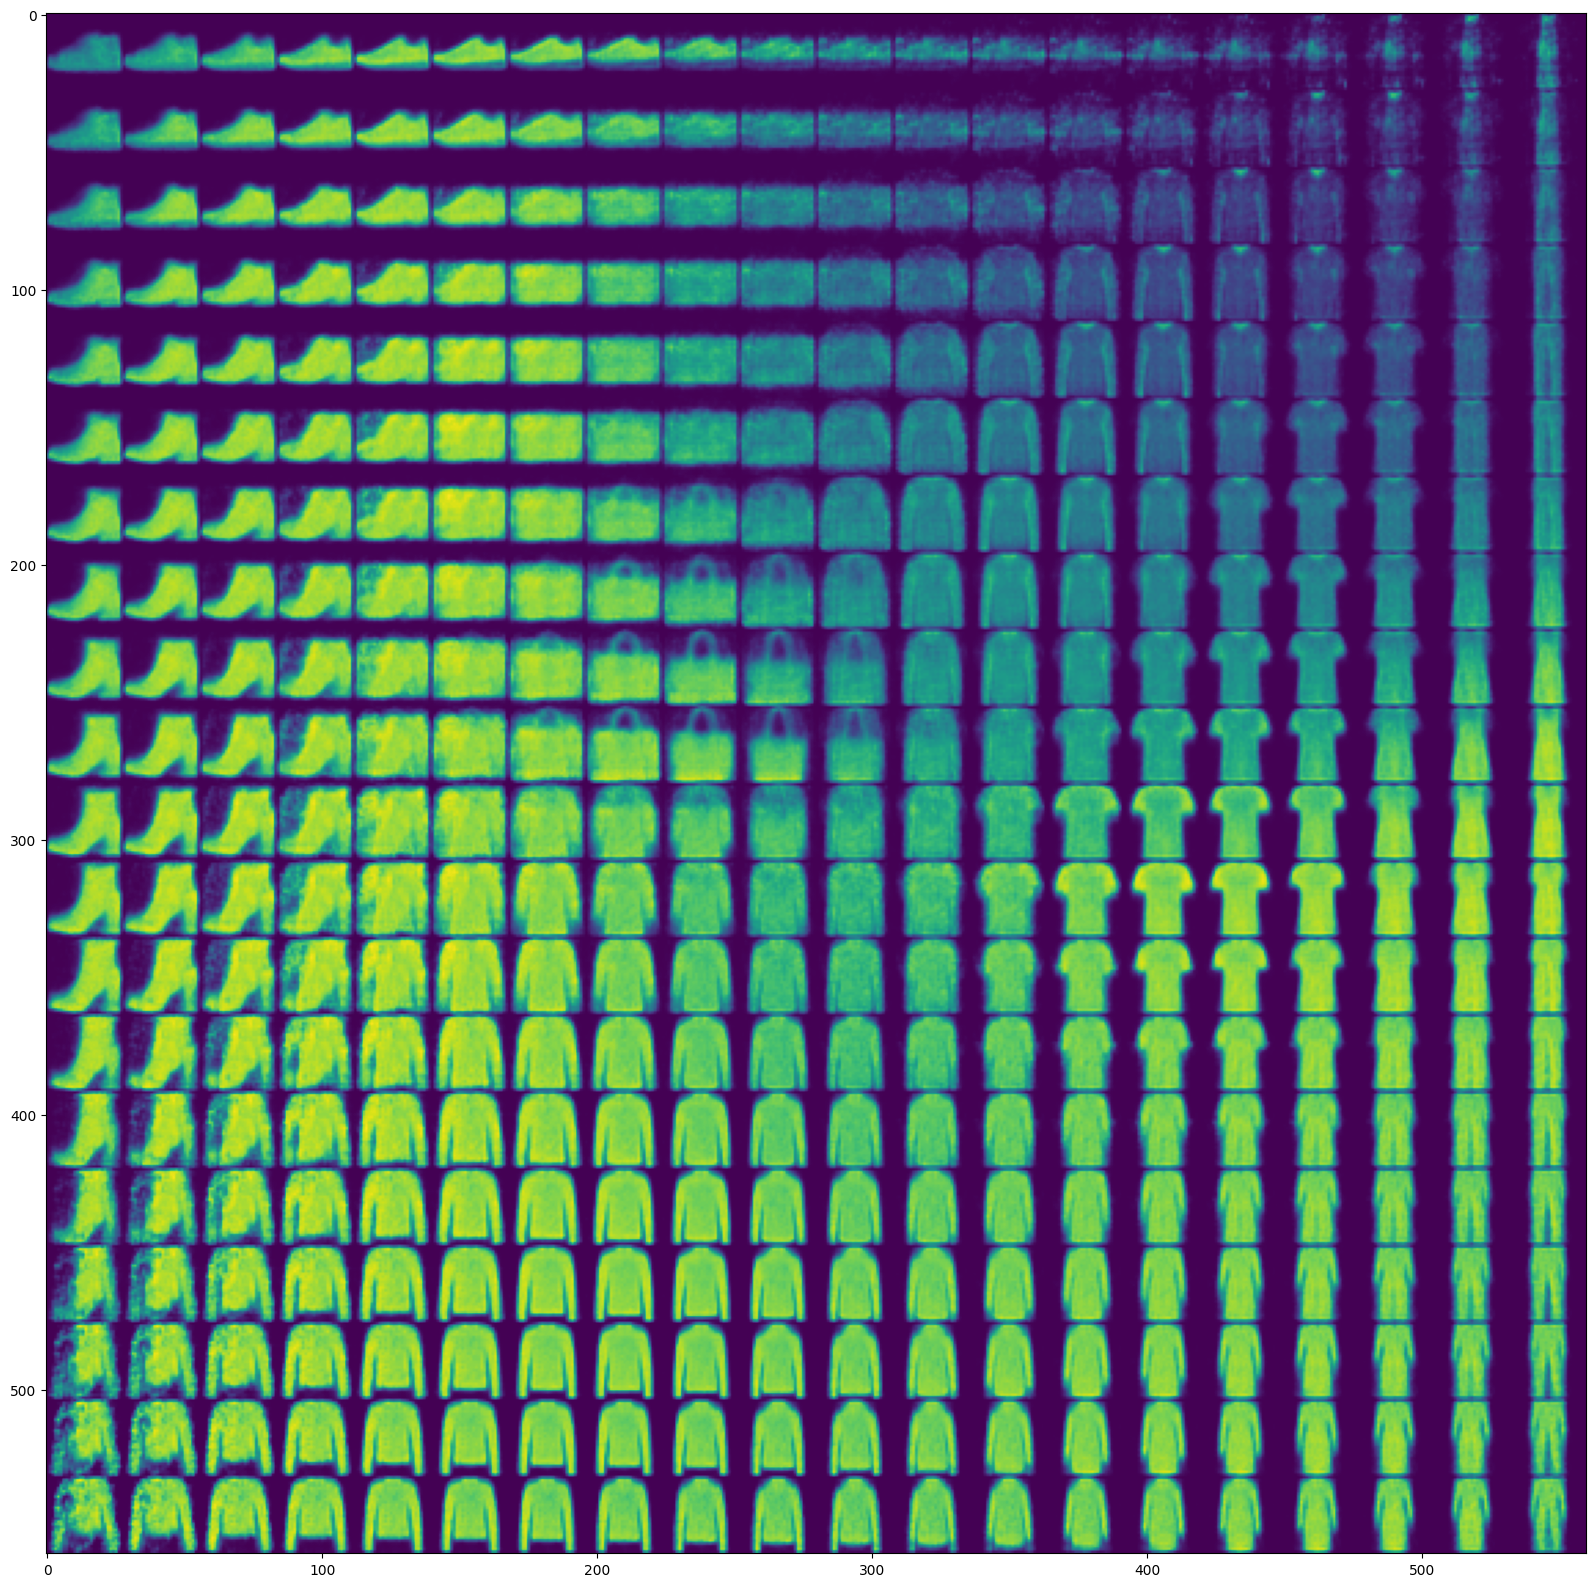

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### VAE: Visualize Latent Space

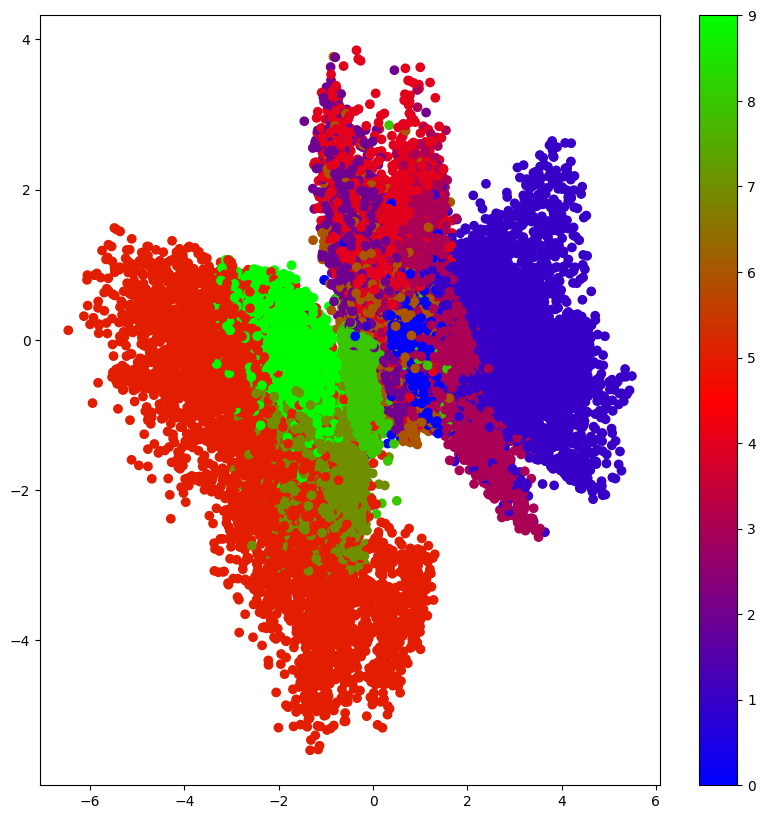

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Exercise: Generating a 1D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

A general function to define feedforward architectures

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))

  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))

  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

Setting GAN training and losses here

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
# hyper-parameters
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1,epochs+1):

        # generate noise from a uniform distribution
        noise = np.random.rand(batch_size,NOISE_DIM)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)

        #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
        #the generator may just produce these features only to exploit the discriminator.
        #The optimization may turn too greedy and produces no long term benefit.
        #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        # Train generator
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                704       
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                128       
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0196613052419974 , GAN : [0.02056417]
3rd order moment -  True :  0.0011626719631519307 , GAN : [-0.00017978]
4th order moment -  True :  3.08592598337304 , GAN : [0.00114255]


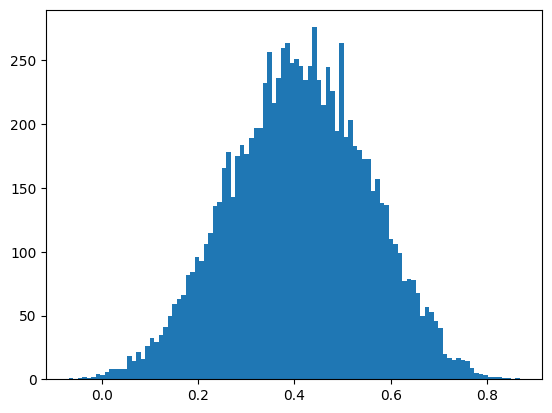

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

**CONCLUSION**

Some conclusions we can make from this exercise:
1. GANs are able to learn a generative model from general noise distributions.
2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)


# Supplementary Activities

## Part 1: MNIST GAN - Learn to Generate MNIST Digits

In [ ]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=e1b934fb300ce8daf3b09625b70b28a4bd4f808288164d7046934077b0069125
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
from keras.datasets import mnist
# from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Re-scale data since we are using ReLU activations. **WHY?**

In [ ]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Set noise dimension

**EXERCISE : Play around with different noise dimensions and plot the performance with respect to the size of the noise vector.**

In [ ]:
z_dim = 100

Tasks:
1. Build Model using LeakyReLU Activations: Build a generator, discriminator, and a GAN as feed-forward network with multiple layers, dropout, and leakyReLU as activation function.
2. Train Model
3. Provide an evaluation/conclusion.

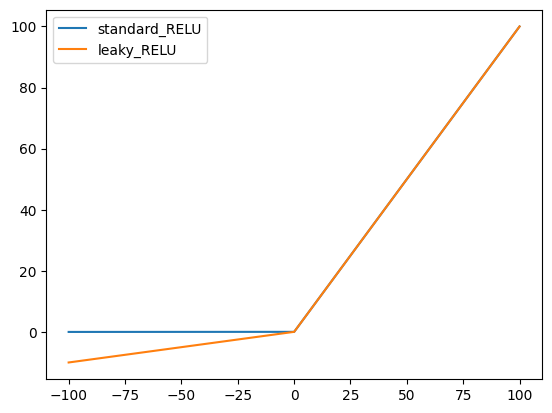

In [ ]:
def leakyReLU(x,neg_scale=0.01):
  if x > 0:
    return x
  else:
    return neg_scale*x

std_relu = []
leaky_relu = []

std_relu = [leakyReLU(x,neg_scale=0) for x in np.linspace(-100,100,10000)]
leaky_relu = [leakyReLU(x,neg_scale=0.1) for x in np.linspace(-100,100,10000)]

plt.plot(np.linspace(-100,100,10000),std_relu, label='standard_RELU')
plt.plot(np.linspace(-100,100,10000),leaky_relu, label='leaky_RELU')
plt.legend()

In [ ]:
adam = tf.keras.optimizers.legacy.Adam(lr=0.0002, beta_1=0.5)

# Generator
generator = Sequential()
generator.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(784, activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# GAN
discriminator.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = generator(inputs)
output = discriminator(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    discriminator_loss = [v[0] for v in losses["D"]]
    generator_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(discriminator_loss, label="Discriminator loss")
    plt.plot(generator_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Generate the images from the noise
            generated_images = generator.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            discriminator.trainable = True
            discriminator_loss = discriminator.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            generator_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(discriminator_loss)
        losses["G"].append(generator_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


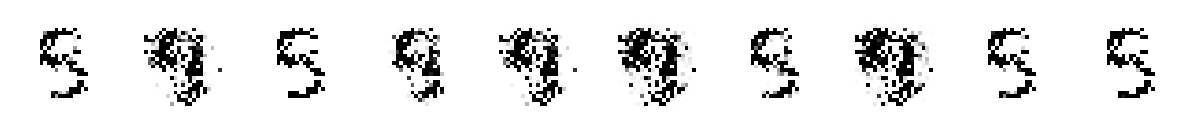

--------------- Epoch 40 ---------------


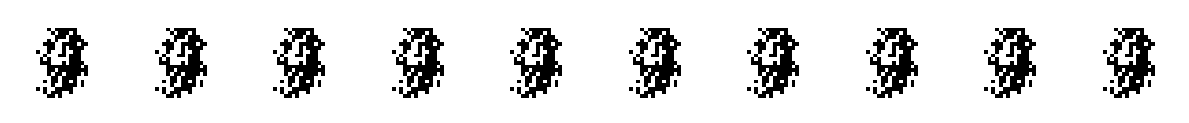

--------------- Epoch 80 ---------------


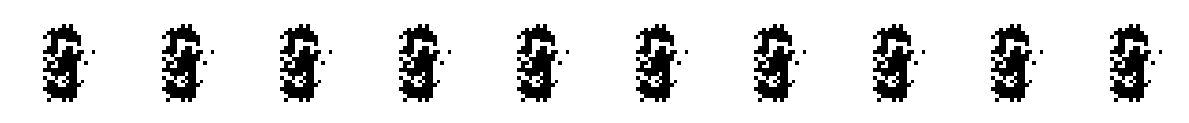

--------------- Epoch 120 ---------------


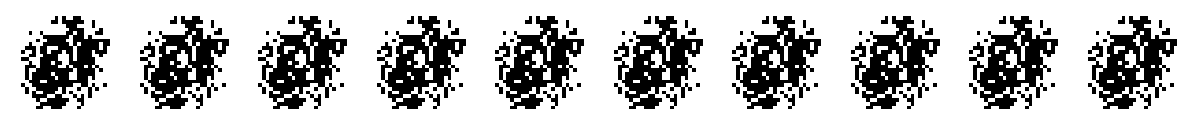

--------------- Epoch 160 ---------------


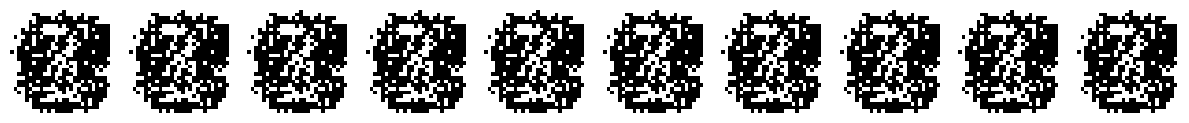

--------------- Epoch 200 ---------------


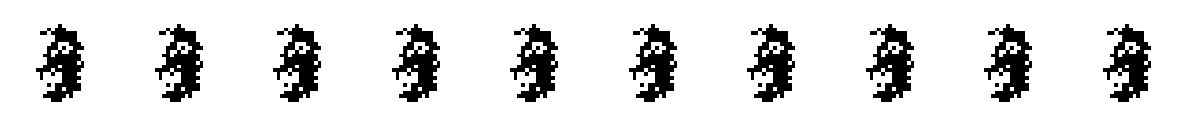

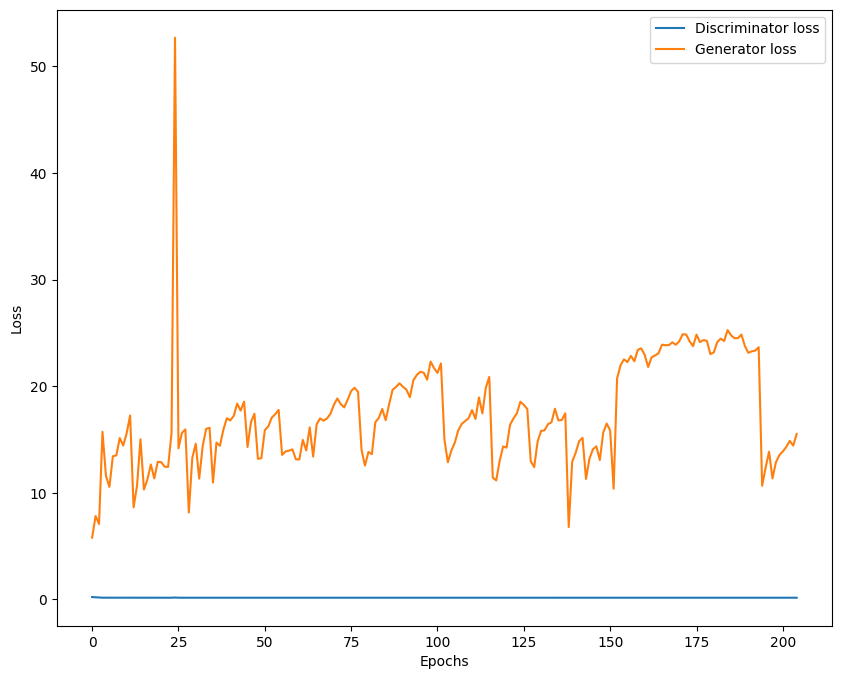

In [ ]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)

## Part 2: GANs and VAEs

Tasks:
1. Use your own dataset.
2. Generate new images using GAN and VAE
3. Compare the results of generating images using GAN and VAE.

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.datasets import mnist

In [ ]:
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)

In [ ]:
# generator network for GAN
generator = keras.Sequential([
    layers.Dense(7 * 7 * 64, input_shape=(100,)),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((7, 7, 64)),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="sigmoid"),
])

# discriminator network for GAN
discriminator = keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1),
])

In [ ]:
# encoder network for VAE
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var])

# decoder network for VAE
latent_inputs = keras.Input(shape=(2,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs)

In [ ]:
# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(z_mean))
        return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

vae = VAE(encoder, decoder)

In [ ]:
# VAE loss function
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

In [ ]:
# Compile the models
discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5))
generator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5))
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=vae_loss)

In [ ]:
# GAN Training
def train_gan(generator, discriminator, epochs, batch_size):
    for epoch in range(epochs):
        for _ in range(x_train.shape[0] // batch_size):
            noise = np.random.normal(0, 1, (batch_size, 100))
            fake_images = generator.predict(noise)
            real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
            discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
            discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, 100))
            generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        print(f"Epoch {epoch+1}, D Loss: {discriminator_loss}, G Loss: {generator_loss}")

In [ ]:
# VAE Training
def train_vae(vae, x_train, epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        for i in range(0, x_train.shape[0], batch_size):
            batch = x_train[i:i + batch_size]
            with tf.GradientTape() as tape:
                z_mean, z_log_var = vae.encoder.predict(batch)
                reconstruction = vae.decoder.predict(z_mean)
                reconstruction_loss = tf.keras.losses.binary_crossentropy(batch, reconstruction)
                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
                total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
            gradients = tape.gradient(total_loss, vae.trainable_variables)
            optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
            epoch_loss_avg.update_state(total_loss)
        print(f"Epoch {epoch+1}, VAE Loss: {epoch_loss_avg.result()}")

In [ ]:
# Generate images from the trained models
def generate_images(generator, vae, num_samples):
    noise = np.random.normal(0, 1, (num_samples, 100))
    fake_images_gan = generator.predict(noise)
    latent_points = np.random.normal(0, 1, (num_samples, 2))
    fake_images_vae = vae.decoder.predict(latent_points)
    return fake_images_gan, fake_images_vae

In [192]:
train_gan(generator, discriminator, epochs=10, batch_size=128)
train_vae(vae, x_train, epochs=10, batch_size=128)
gan_images, vae_images = generate_images(generator, vae, num_samples=1)

Epoch 1, D Loss: -0.0, G Loss: [0.14246908, 1.0]
Epoch 2, D Loss: -0.0, G Loss: [0.14716023, 1.0]
Epoch 3, D Loss: -0.0, G Loss: [0.14439267, 1.0]
Epoch 4, D Loss: -0.0, G Loss: [0.14615771, 1.0]
Epoch 5, D Loss: 7.624619007110596, G Loss: [0.13890128, 1.0]
Epoch 6, D Loss: 7.624619007110596, G Loss: [0.14053667, 1.0]
Epoch 7, D Loss: 7.624619007110596, G Loss: [0.14690372, 1.0]
Epoch 8, D Loss: 7.624619007110596, G Loss: [0.15178801, 1.0]
Epoch 9, D Loss: 7.624619007110596, G Loss: [0.15370993, 1.0]
Epoch 10, D Loss: 7.624619007110596, G Loss: [0.14590654, 1.0]


ValueError: Dimensions must be equal, but are 28 and 128 for '{{node add_7}} = AddV2[T=DT_FLOAT](Mean_1, mul_5)' with input shapes: [128,28,28], [128].

# Conclusion

This activity is all about Generative adversarial network (GAN) and Variational Autoencoders (VAE). GANs and VAEs are techniques used in the field of generative modeling, aiming to create new samples of data resembling those in the training data set. GANs have two neural networks, a generator and a discriminator. The generator learns to produce synthetic data samples from random noise, while the discriminator learns to distinguish between real data and generated samples. Through adversarial training, the generator imrpoves its ability to generate realistic data by tricking the discriminator, which in turn becomes better at distinguishing between real and fake samples. This process results in the generation of high-quality data samples that closely resemble the training data. On the other hand, VAEs operate in an encooder-decoder architecture, with the encoder compressing input data into a latent space representation and the decoder reconstructing the original input from this representation. VAEs are trained using a probabilistic framework, that aims to learn the underlying distribution of the input data. VAEs also optimize a regularization term, typically the Kullback-Leibler (KL) divergency, to encourage VAEs in generating diverse and more meaningful samples of data. Overall, both GANs and VAEs are powerful generative models, each having their own strenghts and weaknesses. Both have applications for tasks such as image generation, text synthesis, and data augmentation, significantly contributing to the field of artificial intelligence and machine learning.

# References


> **Variational Autoencoders and GANs**
>
> Harvard University
>
> Fall 2020
>
> Instructors: Mark Glickman, Pavlos Protopapas, and Chris Tanner
>
> Lab Instructors: Chris Tanner and Eleni Angelaki Kaxiras
>
> Content: Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner
>
> Link: https://harvard-iacs.github.io/2020-CS109B/labs/lab10/notebook/

